Привет! В этот раз для решения задачи ранжирования я  решил использовать XGBRanker.

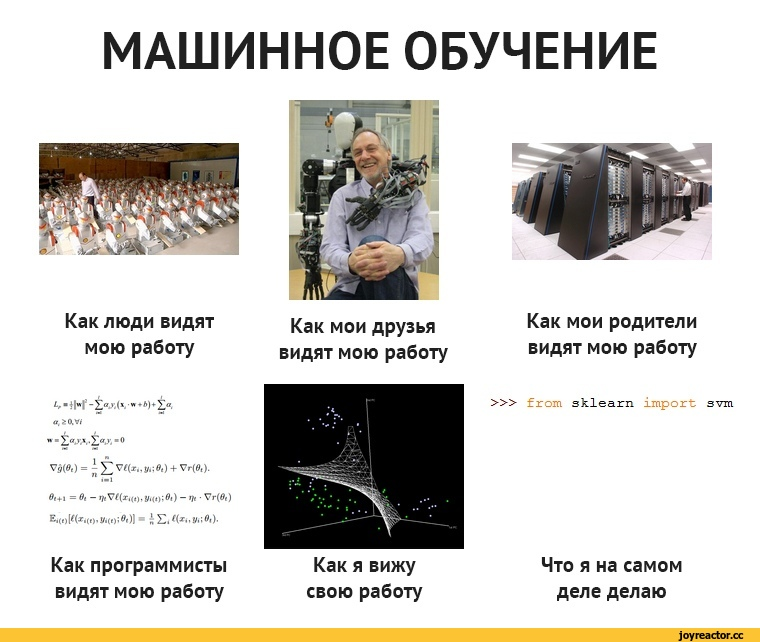

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import random
from sklearn.impute import SimpleImputer
from sklearn.metrics import ndcg_score
import shap

In [ ]:
! gdown --id 1UYWsNmtJko1E1nv3bzj2gkLk0FhTlToc  # загрузка task_data.zip

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1UYWsNmtJko1E1nv3bzj2gkLk0FhTlToc
From (redirected): https://drive.google.com/uc?id=1UYWsNmtJko1E1nv3bzj2gkLk0FhTlToc&confirm=t&uuid=43dafc39-df3a-484b-b15f-fb59db207bc4
To: /content/task_data.zip
100% 354M/354M [00:03<00:00, 91.0MB/s]


In [ ]:
! unzip -n task_data.zip  # распаковка данных и модуля metrics.py

Archive:  task_data.zip


## Метрики
__QSR@5__ - (query soft recall): покрытие запросов релевантными ответами в топ-5 выдачи. Равна доле запросов, в которых в топ-5 выдачи есть хотя бы 1 релевантный документ.
<br/>__recall@5__ - Покрытие релевантных документов документами топ-5 выдачи. Равна доле релевантных документов для всего множества запросов выборки, которые оказались в топ-5 выдачи.
<br/>__NDCG@5__ - Normalized Discounted Cumulative Gain



In [ ]:
def qsr_n(y_true, scores, n=5):
    """
    Покрытие запросов релевантными ответами в топ-5 выдачи.

    :param pd.Series y_true: истинные значения релевантности;
                             индекс соответствует индексу датафрейма scores
    :param pd.DataFrame scores: датафрейм со столбцами:
                                            qn: номер запроса
                                            score: оценка релевантности документа запросу
                                                   (чем выше - тем релевантнее документ)
                              индекс должен соответствовать индексу y_true
    :param int n: top-n документов выдачи для расчёте метрики

    :rtype: float
    """
    doc_rank = scores.groupby('qn').score.rank(ascending=False, method='first')
    return scores[(doc_rank <= n) & (y_true == 1)].qn.nunique() / scores.qn.nunique()


def doc_recall_n(y_true, scores, n=5):
    """
    Покрытие релевентных документом в топ-5 выдачи

    :param pd.Series y_true: истинные значения релевантности;
                             индекс соответствует индексу датафрейма scores
    :param pd.DataFrame scores: датафрейм со столбцами:
                                            qn: номер запроса
                                            score: оценка релевантности документа запросу
                                                   (чем выше - тем релевантнее документ)
                              индекс должен соответствовать индексу y_true
    :param int n: top-n документов выдачи для расчёте метрики

    :rtype: float
    """
    doc_rank = scores.groupby('qn').score.rank(ascending=False, method='first')
    return y_true[doc_rank <= n].sum() / y_true.sum()


def ndcg(y_true, scores, n=5):
    """
    NDCG@n

    :param pd.Series y_true: истинные значения релевантности;
                             индекс соответствует индексу датафрейма scores
    :param pd.DataFrame scores: датафрейм со столбцами:
                                            qn: номер запроса
                                            score: оценка релевантности документа запросу
                                                   (чем выше - тем релевантнее документ)
                              индекс должен соответствовать индексу y_true
    :param int n: top-n документов выдачи для расчёте метрики

    :rtype: float
    """
    num_doc_per_query = 100
    num_queries = scores.qn.nunique()
    return ndcg_score(y_true.values.reshape(num_doc_per_query, num_queries),
                      scores.score.values.reshape(num_doc_per_query, num_queries), k=n)

Посмотрим на датасет

In [ ]:
data_path = 'task_data'

df_train = pd.read_csv(f'{data_path}/train_feats.csv', index_col=0)
y_true = pd.read_csv(f'{data_path}/train_target.csv', index_col=0).is_rel
df_test = pd.read_csv(f'{data_path}/test_feats.csv', index_col=0)

In [ ]:
df_train.head()

,qn,r1,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,...,feat35,feat36,feat37,feat38,feat39,feat40,feat41,feat42,feat43,feat44
0,1,0.332747,8.5,1.227210,0.32927,30,1.44034,0.11980,NaN,0.581109,...,0.45399,1.20762,581,3,0.21429,0.26081,2.601839,9.19239,8.50,NaN
1,1,0.314105,5.0,1.390449,0.31644,33,1.84999,0.21025,1.0,0.030689,...,0.43631,1.36860,774,4,0.22581,0.18264,4.257145,4.11299,5.75,1.0
2,1,0.299312,8.5,1.398685,0.33053,19,2.97154,0.11980,NaN,0.002043,...,0.45573,1.49769,467,3,0.21429,0.19453,3.854823,9.19239,8.50,NaN
3,1,0.296625,NaN,1.414797,0.37267,70,1.00000,NaN,NaN,0.198333,...,0.51383,1.00000,679,5,NaN,0.45431,4.061113,NaN,NaN,NaN
4,1,0.290262,NaN,1.354881,0.44265,36,1.00000,NaN,NaN,0.260875,...,0.61032,1.00000,478,6,NaN,0.32856,4.593775,NaN,NaN,NaN


Хотелось бы посмотреть описательные статистики фичей , но послько признаков много и они обезличены в этом нет особого смысла.Выводы о пользе фичей сделаю после построения модели, каких-то предположений сделать не могу из-за отсутствия названий фичей

In [ ]:
df_train.describe()

,qn,r1,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,...,feat35,feat36,feat37,feat38,feat39,feat40,feat41,feat42,feat43,feat44
count,3.000000e+06,3.000000e+06,681612.000000,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,681612.000000,527764.000000,3.000000e+06,...,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,681612.000000,3.000000e+06,3.000000e+06,460322.000000,681612.000000,527764.000000
mean,1.500050e+04,2.810183e-01,19.025407,1.386164e+00,4.688996e-01,1.125781e+02,2.356664e+00,0.498292,0.897445,1.670098e-01,...,4.338249e-01,1.438874e+00,2.373372e+03,9.076888e+00,1.151859,2.919486e-01,3.500019e+00,12.199209,20.124957,9.865226
std,8.660255e+03,8.442072e-02,13.824034,6.172475e-02,2.062403e-01,7.016705e+02,9.056261e+00,0.619420,0.139913,1.558864e-01,...,1.349049e-01,2.615320e+00,1.445719e+04,5.827189e+01,2.296956,1.998319e-01,6.455597e-01,8.547557,13.365042,13.335533
min,1.000000e+00,5.669000e-02,1.000000,1.175210e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000,0.666670,7.849277e-14,...,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000,0.000000e+00,2.000646e+00,0.000000,1.000000,1.000000
25%,7.500750e+03,2.215850e-01,9.000000,1.353511e+00,3.290100e-01,1.600000e+01,1.000000e+00,0.253780,0.750000,3.106410e-02,...,3.587000e-01,1.000000e+00,2.940000e+02,0.000000e+00,0.322220,1.490600e-01,2.999972e+00,4.966550,10.000000,2.000000
50%,1.500050e+04,2.692075e-01,14.500000,1.393260e+00,4.495400e-01,3.400000e+01,1.000000e+00,0.383990,1.000000,1.225306e-01,...,4.435400e-01,1.000000e+00,7.320000e+02,2.000000e+00,0.541670,3.166200e-01,3.500327e+00,11.196730,17.000000,5.000000
75%,2.250025e+04,3.276250e-01,25.000000,1.429735e+00,5.945700e-01,7.100000e+01,1.454390e+00,0.550000,1.000000,2.682986e-01,...,5.255200e-01,1.180720e+00,1.509000e+03,6.000000e+00,0.757580,4.332500e-01,3.999961e+00,17.884800,27.000000,12.000000
max,3.000000e+04,9.122675e-01,302.000000,1.499992e+00,1.307910e+00,1.728400e+04,5.427520e+02,28.000000,1.000000,5.838532e-01,...,7.000000e-01,1.165615e+02,4.845880e+05,3.025000e+03,42.000000,9.908000e-01,4.999347e+00,207.182290,302.000000,198.000000


Сейчас займусь предобработкой данных
Для начала посмотрю на количество пропусков в датасете

In [ ]:
df_train.isna().sum()

,0
qn,0
r1,0
feat1,2318388
feat2,0
feat3,0
feat4,0
feat5,0
feat6,2318388
feat7,2472236
feat8,0


In [ ]:
df_test.isna().sum()

,0
qn,0
r1,0
feat1,774020
feat2,0
feat3,0
feat4,0
feat5,0
feat6,774020
feat7,827471
feat8,0


Очень  много пропусков в фичах , все признаки вещественные поэтому заполню пропуски средними значениями. Пропуски в тесте буду заполнять значениями из трейна для того чтобы избежать лик таргета

In [ ]:
imp_mean = SimpleImputer(missing_values=pd.NA,strategy='mean')
columns_with_missing = df_train.columns[df_train.isnull().any()].tolist()
imp_mean.fit(df_train[columns_with_missing])
df_train[columns_with_missing] = imp_mean.transform(df_train[columns_with_missing])
df_test[columns_with_missing] = imp_mean.transform(df_test[columns_with_missing])

In [ ]:
df_train.isna().sum()

,0
qn,0
r1,0
feat1,0
feat2,0
feat3,0
feat4,0
feat5,0
feat6,0
feat7,0
feat8,0


In [ ]:
df_test.isna().sum()

,0
qn,0
r1,0
feat1,0
feat2,0
feat3,0
feat4,0
feat5,0
feat6,0
feat7,0
feat8,0


От пропусков избавился. В датасете все признаки вещественные , отмасштабирую их

In [ ]:
columns_to_scale = [col for col in df_train.columns if col != 'qn' and col != 'r1']
scaler = StandardScaler()
scaler.fit(df_train[columns_to_scale])
df_train[columns_to_scale] = scaler.transform(df_train[columns_to_scale])
df_test[columns_to_scale] = scaler.transform(df_test[columns_to_scale])

Значения заскейлил , скейлер обучал только на трейновых данных для того чтобы избежать лика таргета

In [ ]:
df_train

,qn,r1,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,...,feat35,feat36,feat37,feat38,feat39,feat40,feat41,feat42,feat43,feat44
0,1,0.332747,-1.597337e+00,-2.575209,-0.677024,-0.117688,-0.101181,-1.281929e+00,0.000000,2.656415,...,0.149476,-0.088423,-0.123978,-0.104285,-0.856333,-0.155824,-1.391319,-8.980398e-01,-1.824792e+00,-1.270343e-15
1,1,0.314105,-2.128497e+00,0.069427,-0.739233,-0.113412,-0.055947,-9.755804e-01,1.747589,-0.874492,...,0.018421,-0.026870,-0.110628,-0.087124,-0.845811,-0.547003,1.172822,-2.415092e+00,-2.256465e+00,-1.584968e+00
2,1,0.299312,-1.597337e+00,0.202856,-0.670914,-0.133365,0.067895,-1.281929e+00,0.000000,-1.058251,...,0.162374,0.022489,-0.131863,-0.104285,-0.856333,-0.487503,0.549607,-8.980398e-01,-1.824792e+00,-1.270343e-15
3,1,0.296625,2.695801e-15,0.463876,-0.466590,-0.060681,-0.149804,-3.760258e-16,0.000000,0.200933,...,0.593048,-0.167809,-0.117199,-0.069963,0.000000,0.812490,0.869160,-4.774864e-15,2.230705e-15,-1.270343e-15
4,1,0.290262,2.695801e-15,-0.506810,-0.127277,-0.109137,-0.149804,-3.760258e-16,0.000000,0.602137,...,1.308293,-0.167809,-0.131102,-0.052802,0.000000,0.183211,1.694277,-4.774864e-15,2.230705e-15,-1.270343e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999995,30000,0.192370,2.695801e-15,0.183160,0.645802,-0.147616,-0.149804,-3.760258e-16,0.000000,-0.093379,...,0.282681,-0.167809,-0.156349,-0.155768,0.000000,0.027881,-0.838253,-4.774864e-15,2.230705e-15,-1.270343e-15
2999996,30000,0.192365,2.120785e+00,1.163723,-2.273559,-0.117688,-0.149804,-2.728922e-01,0.000000,-1.064267,...,-3.215785,-0.167809,-0.086142,-0.155768,-0.670529,0.272586,-0.191548,-4.774864e-15,2.021020e+00,-1.270343e-15
2999997,30000,0.191895,2.695801e-15,-0.250454,0.821519,-0.149042,-0.149804,-3.760258e-16,0.000000,1.022092,...,0.493274,-0.167809,-0.154897,-0.155768,0.000000,-0.123797,1.328090,-4.774864e-15,2.230705e-15,-1.270343e-15
2999998,30000,0.189302,2.695801e-15,0.477848,-0.676345,-0.119113,-0.149804,-3.760258e-16,0.000000,0.136571,...,-1.301769,-0.167809,-0.138711,-0.035641,0.000000,-0.501615,-1.217879,-4.774864e-15,2.230705e-15,-1.270343e-15


Для построения модели ранжирования буду использовать pairwise подход ,а именно модель XGBRanker c функционалом ndcg, выбрал это функционал т.к. в задании как раз таки требуется улучшить эту метрику , а когда есть возможноть оптимизировать метрику напрямую это как мне кажется нужно делать

In [ ]:
ranker = xgb.XGBRanker(objective="rank:ndcg")
ranker.fit(df_train[columns_to_scale], y_true, qid=df_train['qn'])

XGBRanker(base_score=None, booster=None, callbacks=None, colsample_bylevel=None,
          colsample_bynode=None, colsample_bytree=None, device=None,
          early_stopping_rounds=None, enable_categorical=False,
          eval_metric=None, feature_types=None, feature_weights=None,
          gamma=None, grow_policy=None, importance_type=None,
          interaction_constraints=None, learning_rate=None, max_bin=None,
          max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None,
          max_depth=None, max_leaves=None, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=None,
          n_jobs=None, num_parallel_tree=None, ...)

Конечно было бы хорошо сплитануть трейн еще на валидационную выборку и подобрать на ней гиперпараметры , но XGB неплохо работает 'из коробки' и в целях экономии времени решил это не делать

In [ ]:
scores_of_new_model = ranker.predict(df_train[columns_to_scale])

In [ ]:
scores_of_new_model

array([-1.3848431, -1.156582 , -1.2027283, ..., -4.062495 , -5.086458 ,
       -5.5909147], dtype=float32)

In [ ]:
random.seed(78)

scores_list = [
    ('Случайная сортировка', y_true, df_train.assign(score=lambda df: [random.random() for i in range(df.shape[0])])[['qn', 'score']]),
    ('Baseline (сортировка ретривера)', y_true, df_train.assign(score=lambda df: df.r1)[['qn', 'score']]),
    ('Идеальная сортировка', y_true, df_train.assign(score=y_true)[['qn', 'score']]),
    ('Сортировка XGB', y_true, df_train.assign(score=scores_of_new_model)[['qn', 'score']]),
]


metrics_list = [
    ('QSR@5', qsr_n),
    ('Recall@5', doc_recall_n),
    ('NDCG@5', ndcg)
]


result = dict()
result['submit'] = [name for name, _, _ in scores_list]
for metric_name, metric_func in metrics_list:
    result[metric_name] = []
    for submit_name, _y_true, scores in scores_list:
        result[metric_name].append(metric_func(_y_true, scores, n=5))

print('Метрики на всём обучающем датасете:')
df_result = pd.DataFrame(result).round(3)
df_result

Метрики на всём обучающем датасете:


,submit,QSR@5,Recall@5,NDCG@5
0,Случайная сортировка,0.059,0.049,0.012
1,Baseline (сортировка ретривера),0.260,0.297,0.304
2,Идеальная сортировка,0.677,0.985,1.000
3,Сортировка XGB,0.512,0.661,0.759


Все метрики возрасли  в 2-2.5 раза, модель отлично справляется с задачей ранжирования.

С чем может быть связано улучшение:


1.   Retrieval-методы выдают релевантные методы , но при этом не учитывают правильность порядка , чо видно в увеличении NDCG в 2.5 раза
2.   Предобработка данных - в  изначальном датасете почти у половины фичей было пропущено большинство значений, заполнение пропусков позволило моделе учитывать большее количество признаков
3.   В качестве модели был выбран XGBRanker  с функционалом NDCG, оптимизация под итоговую метрику позволила значительно улучшить результаты
4.   Использование модели на основе градиентного бустнига позволяет находить нелинейные зависимости в данных и как мы знаем градиентный бустинг на табличных данных это - 'piece of art' решение
5.   XGBRanker использует pairwise подход к ранжированию , что позволяет учитывать порядок выдачи и оптимизироватсья под метрику

Конечно же метрики полученные моделью не идеальны и их можно улучшить с помощью подбора гиперпараметров и тщательного feature engineering-a







Теперь посмотрим на то какие фичи оказали наибольшее влияние на прогноз модели. Поскольку датасет большой то для оценки важности фичей возьму батч размером 50 тысяч строки.Для оценки важности фичей буду использовать SHAP т.к. считаю его наиболее информативным способом , конечно в идеале было бы построить его на всем датасете , но за разумное время он не построится. Permutation importance на таком болльшом датасете тоже работал бы долго и не дает глубоко понимания влияния фичей

In [ ]:
sample_idx = np.random.choice(len(df_train[columns_to_scale]), size=50_000, replace=False)
X_sample = df_train[columns_to_scale].iloc[sample_idx]
explainer = shap.TreeExplainer(ranker)
shap_values = explainer.shap_values(X_sample)

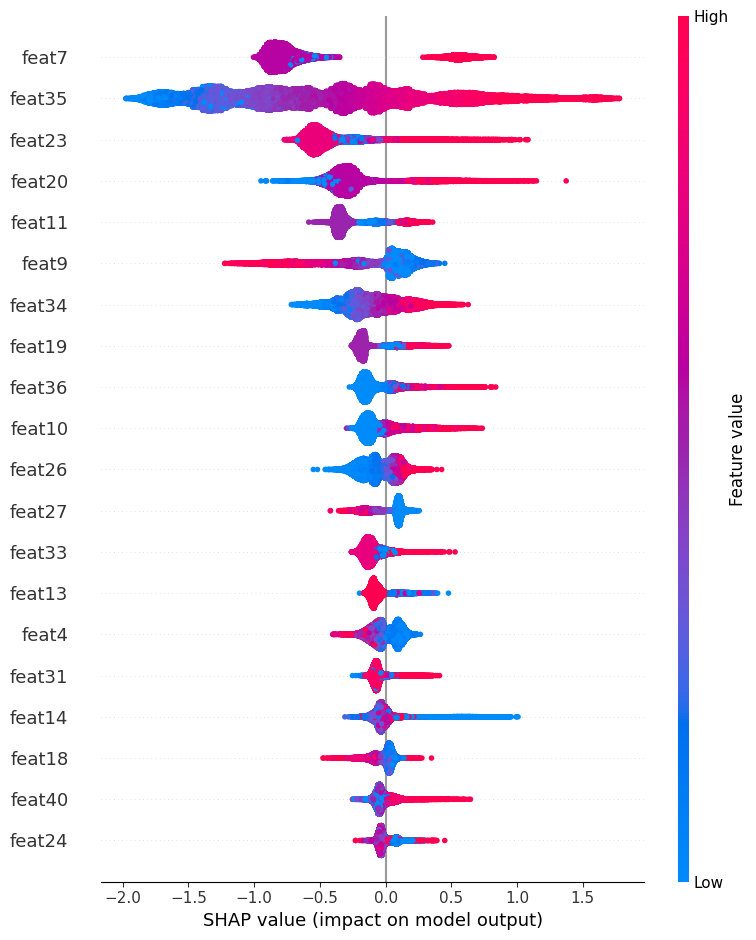

In [ ]:
shap.summary_plot(shap_values, X_sample)

Интерпретирую первые 3 переменные:


1.   feature7 - оказалась наиболее важным признаком , значения фичи бинарные (1/0) могу предположить , что эта фича по типу: пользователь покупал товар или не покупал , взаимодейстовал или нет. Что логично ведь зачастую полезнее всего выдавать товары знакомые пользователю первыми .Высокие значения повышают ранк объекта ,а низкие понижают
По следующим фичам особо ничего не скажешь без знания их названия поэтом просто опишу как влияли
2.   feature35 - высокие значения повышают ранг , низкие понижают
3.   feature23 - высокие значения повышают ранг , низкие понижают

Что касается остальных признаков можно заметить , что большинство из них практически не влияли на прогнозы модели ,а значит их можно было бы выкинуть





Теперь сделаю предсказание на тесте для 'сабмита'

In [21]:
test_scores = ranker.predict(df_test[columns_to_scale])

In [22]:
pd.Series(test_scores, index=df_test.index, name='score').to_csv('test_scores.csv')